# San Francisco Crime

### Considerations
This jupyter notebook uses a Python 3 Kernel.

### Imports

In [12]:
import pandas as pd
import matplotlib
import seaborn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
seaborn.set()

### Map
Before we dive into the data, we look at the map of San Francisco

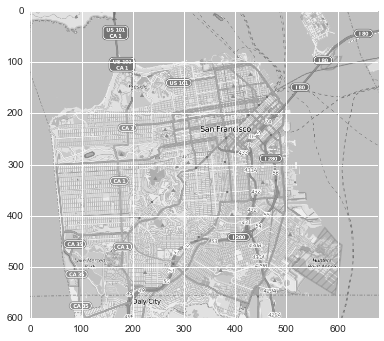

In [15]:
mapdata = np.loadtxt("../data/sf_map_copyright_openstreetmap_contributors.txt")
plt.imshow(mapdata, cmap = plt.get_cmap('gray'))

## Data
### Import Data

In [33]:
data_train_row = pd.read_csv('../data/train.csv', sep = ',')

### Rough Data Analysis
We see that there are 878049 observations and no missing values.

In [18]:
data_train_row.describe(percentiles=[]).transpose()

count        mean       std         min         50%    max
X  878049.0 -122.422616  0.030354 -122.513642 -122.416420 -120.5
Y  878049.0   37.771020  0.456893   37.707879   37.775421   90.0

TODO

In [6]:
data_train_row.describe(percentiles=[], include=['O']).transpose()

count  unique                           top    freq
Dates       878049  389257           2011-01-01 00:01:00     185
Category    878049      39                 LARCENY/THEFT  174900
Descript    878049     879  GRAND THEFT FROM LOCKED AUTO   60022
DayOfWeek   878049       7                        Friday  133734
PdDistrict  878049      10                      SOUTHERN  157182
Resolution  878049      17                          NONE  526790
Address     878049   23228        800 Block of BRYANT ST   26533

### Target Variable
The target to predict the category of crime. There are 39 unique categories.

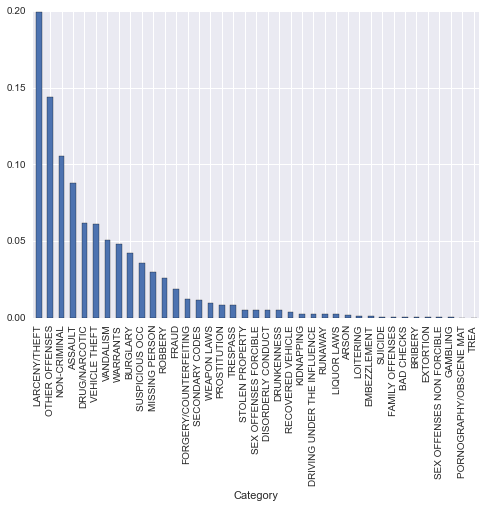

In [19]:
d = data_train_row.groupby('Category').size().sort_values(ascending=False)
dPercent[:].plot(kind="bar")

The top 15 categories contain over 93% of all crimes, so we dicide to use and to predict only them.

In [20]:
dPercent[:15].sum()

0.93318710003655825

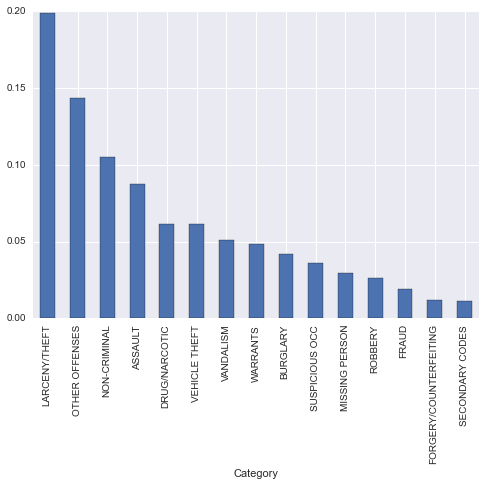

In [21]:
dPercent = d / d.sum()
dPercent[:15].plot(kind='bar')

Therefore we drop all other crime data.

In [46]:
print('number of all  samples: ',data_train_row.shape[0] )
list_of_used_crime = np.asarray(dPercent[:15].index)
data_train = data_train_row[data_train_row['Category'].isin(list_of_used_crime)]
print('number of used samples: ',data_train.shape[0] )

number of all  samples:  878049
number of used samples:  819384


### Test Data
The training data and test data rotate every week. Besides the target variable "Category" also "Descript" and "Resolution" are missing from the the test set.

In [48]:
data_test = pd.read_csv('../data/test.csv', sep = ',')

### Data Anmalies
#### LongLat
First convert all X/Y Values to numeric to be able to compare them.

In [49]:
d_train_x = pd.to_numeric(data_train['X'])
d_train_y = pd.to_numeric(data_train['Y'])
d_test_x = pd.to_numeric(data_test['X'])
d_test_y = pd.to_numeric(data_test['Y'])

In [50]:
data_train["X"][(d_train_x < -122.52469) | (d_train_x > -122.33663)].unique()

array([-120.5])

In [51]:
data_train["Y"][(d_train_y < 37.69862) | (d_train_y > 37.82986)].unique()

array([ 90.])

In [52]:
data_test["X"][(d_test_x < -122.52469) | (d_test_x > -122.33663)].unique()

array([-120.5])

In [53]:
data_test["Y"][(d_test_y < 37.69862) | (d_test_y > 37.82986)].unique()

array([ 90.])

### Features

#### Day of week

In [113]:
    def feature_day_of_week(data):
        names =  data['DayOfWeek'].unique()
        return pd.get_dummies(data['DayOfWeek']), names.tolist()

#### PdDistrict
'NORTHERN', 'PARK', 'INGLESIDE', 'BAYVIEW', 'RICHMOND', 'CENTRAL','TARAVAL', 'TENDERLOIN', 'MISSION', 'SOUTHERN'

In [114]:
def feature_pd_district(data):
    names = data['PdDistrict'].unique()    
    return pd.get_dummies(data['PdDistrict']), names.tolist()

#### X (Longitude)
TODO

In [ ]:
def feature_longitude(data):


#### Time-based

In [56]:
def year(data):
    df = data
    df['year'] = pd.to_datetime(data['Dates']).dt.year
    years = np.asarray(pd.get_dummies(df['year']))
    return years 

In [111]:
def feature_daytime(data):
    datetime = pd.DatetimeIndex(data['Dates'], format='%H')#%Y-%m-%d %H:%M:%S') #split up in date and time?
    night = np.any([datetime.hour >= 22, datetime.hour < 6], axis=0).reshape(datetime.shape[0],1)
    morning = np.all([datetime.hour >= 6, datetime.hour < 11], axis=0).reshape(datetime.shape[0],1)
    noon = np.all([datetime.hour >= 11, datetime.hour < 15], axis=0).reshape(datetime.shape[0],1)
    afternoon = np.all([datetime.hour >=15, datetime.hour < 18], axis=0).reshape(datetime.shape[0],1)
    evening = np.all([datetime.hour >=18, datetime.hour < 22], axis=0).reshape(datetime.shape[0],1)
    daytimes = ['night', 'morning', 'noon', 'afternoon', 'evening']
    daytimemat = np.concatenate([night, morning, noon, afternoon, evening],axis=1)
    return daytimemat, daytimes

In [112]:
def feature_seasons(data):
    datetime = pd.DatetimeIndex(data['Dates'], format='%H')
    winter = np.any([datetime.month >= 12, datetime.hour < 3], axis=0).reshape(datetime.shape[0],1)
    spring = np.all([datetime.hour >= 3, datetime.hour < 6], axis=0).reshape(datetime.shape[0],1)
    summer = np.all([datetime.hour >= 6, datetime.hour < 9], axis=0).reshape(datetime.shape[0],1)
    fall = np.all([datetime.hour >=9, datetime.hour < 12], axis=0).reshape(datetime.shape[0],1)
    daytimes = ['winter', 'spring', 'summer', 'fall']
    daytimemat = np.concatenate([winter, spring, summer, fall],axis=1)
    return daytimemat, daytimes

#### Address-based

In [115]:
def feature_street_corner(data):
    d = np.asarray(data['Address'].apply(lambda x: 1 if '/' in x else 0))
    d = d.reshape(d.shape[0],1)
    return d, ["Street Corner"]

#### Location-based

In [86]:
def regions(data):
    #preprocessing should kill the outlier
    df = data
    cutX = pd.qcut(data.X, 5, labels=[1,2,3,4,5])
    cutY = pd.qcut(data.Y, 5, labels=[1,2,3,4,5])
    df['cutX'] = cutX
    df['cutY'] = cutY
    sumF = df['cutX'] * 6 + df['cutY']
    features = pd.get_dummies(sumF)
    return np.asarray(features)

### Left out Features
TODO

### Generate Feature Set

In [118]:
def getY(data):
    return pd.get_dummies(data['Category'])

def getX(data):
    feats = []
    names = []
    
    f,n = feature_day_of_week(data)
    feats.append(f)
    names.append(n)    
    f,n = feature_pd_district(data)
    feats.append(f)
    names.append(n)    
    #f,n = feature_year(data)
    #feats.append(f)
    #names.append(n)    
    f,n = feature_daytime(data)
    feats.append(f)
    names.append(n)    
    f,n = feature_seasons(data)
    feats.append(f)
    names.append(n)    
    f,n = feature_street_corner(data)
    feats.append(f)
    names.append(n)    
    
    data_set = np.concatenate([f for f in feats], axis=1).astype(float)
    return data_set, sum(names, [])

In [119]:
print("get train features")
train_x, names = getX(data_train)
train_y = getY(data_train)

print("get test features")
test_x, names_test = getX(data_test)


get train features
get test features


### Split in training and validation set

In [132]:
size_valid = int(train_x.shape[0] * 0.1)
valid_x = train_x[:size_valid]
valid_y = train_x[:size_valid]
train_x = train_x[size_valid:]
train_y = train_y[size_valid:]

### Feature Selection

#### PCA

TODO

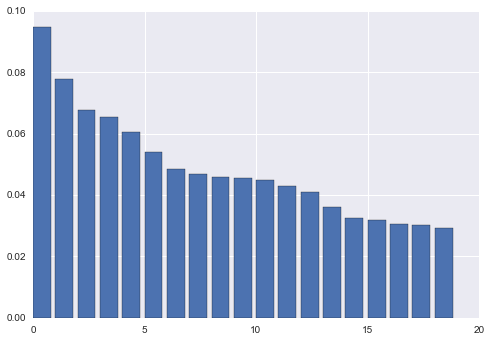

[ 0.29408494  0.24208581  0.21049199  0.2035097   0.18791722  0.16747828
  0.15104998  0.14553387  0.14276735  0.14182595  0.13982965  0.13329985
  0.12716968  0.11202158  0.10072054  0.09852434  0.09449146  0.09347296
  0.09079122]


In [120]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9)
pca.fit(train_x)
pc = pca.explained_variance_

plt.bar(np.arange(pc.shape[0]), pca.explained_variance_ratio_)
plt.show()
print(pc)

#### Random Forest
TODO

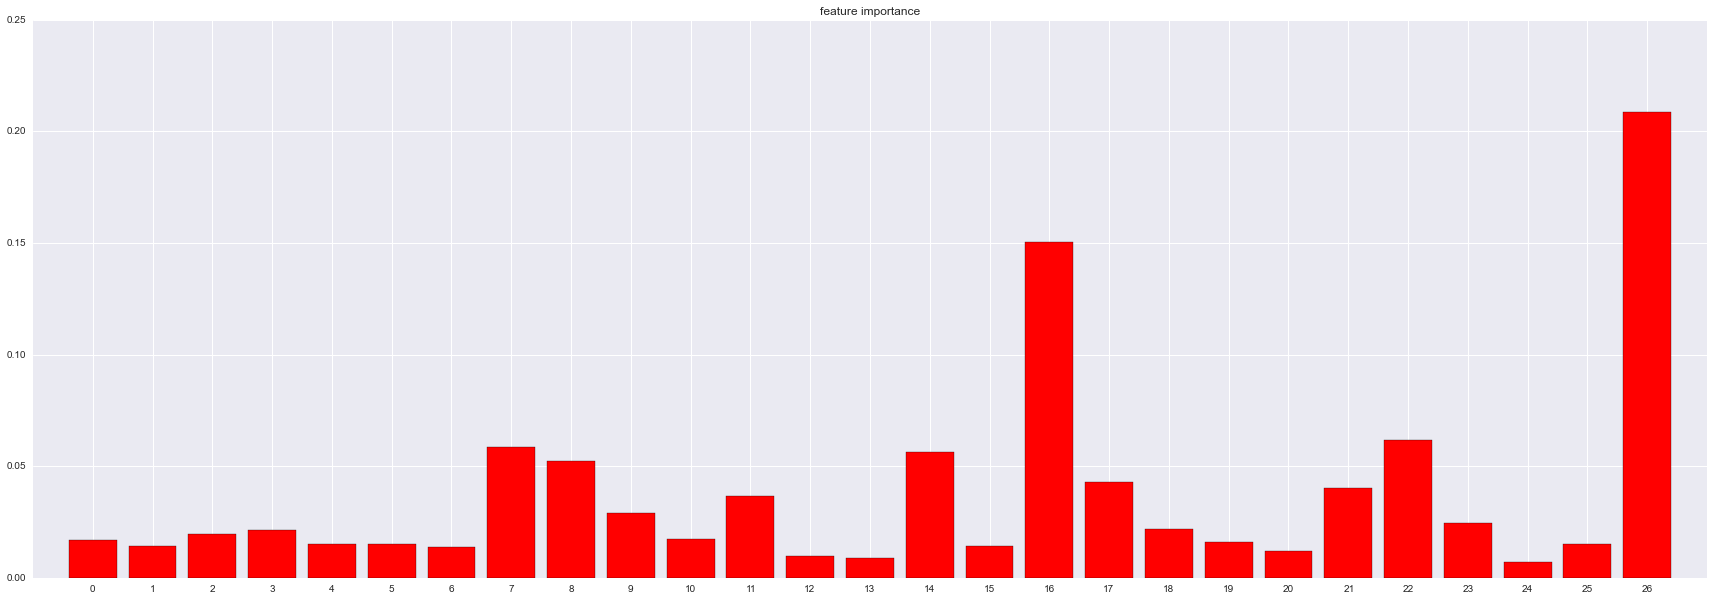

0 Wednesday 0.0168995602307
1 Tuesday 0.0143429284067
2 Monday 0.0195397639783
3 Sunday 0.0215418134874
4 Saturday 0.0151293195394
5 Friday 0.0152686523848
6 Thursday 0.0137615625327
7 NORTHERN 0.0586647439049
8 PARK 0.0521221695839
9 INGLESIDE 0.0289759786113
10 BAYVIEW 0.0174496996165
11 RICHMOND 0.0365125051006
12 CENTRAL 0.00961435118553
13 TARAVAL 0.00908858609419
14 TENDERLOIN 0.0562163497924
15 MISSION 0.0143591936384
16 SOUTHERN 0.150480848637
17 night 0.0430601019519
18 morning 0.0216638052126
19 noon 0.0161962915257
20 afternoon 0.0119519008557
21 evening 0.0401266624352
22 winter 0.0619362531209
23 spring 0.0243464638805
24 summer 0.00687342426379
25 fall 0.0151004968932
26 Street Corner 0.208776573136


In [133]:
from sklearn.ensemble import RandomForestClassifier

model =RandomForestClassifier(n_estimators=1)


train = model.fit(train_x, train_y)
pred = model.predict(valid_x)

# feature importance
importance = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importance)[::-1]

#bar chart plot for feature importance
#because of the huge number of the features, legend of the bars are shown in the terminal
plt.figure(figsize=(30, 10))
plt.title("feature importance")
plt.bar(range(importance.shape[0]), importance, color="r", align="center")
plt.xlim([-1, importance.shape[0]])
plt.xticks(range(importance.shape[0]))
plt.show()

counter = 0
for i in range(indices.shape[0]):
        print(str(i) + " " + names[i] + " " + str(importance[i]))

## Classification
For each tried Classifier we output the accuracy and the DMC metric. After that we select the one which has the best score (lower is better).

In [ ]:
#def sfc_eval(pred, true):
    #TODO

### Logistic Regression
The logistic regression is a statistical approach to predict the class labels. It needs some assumptions like binomial distribution for the response variable. The Classificator trains for every label an separate regression model. The model with the highest likelihood gets the classification. This model provides a good result in our case.

In [134]:
from Classifiers.LogisticRegression import classifier_lr

classifier_lr(train_x, train_y, test_x, test_y)

ImportError: No module named 'Classifiers'

### Naive Bayes
This model is also a statistical approach. It trains a Naive bayes network and classifies the data with the aposteriori likelihood. Its a very fast benchmark classificator which provides in this case the poorest results

In [ ]:
from Classifiers.NaiveBayes import classifier_nb

classifier_nb(train_x, train_y, test_x, test_y)

### Random Forest
Random Forest is classificator which generates many decision trees with random samples. For every tree it try to maximize the information gain. It classifies according to a majority decision

In [148]:
# Choose Classifier Here and Give it a Name
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
name = "Random Forest "

def classifier_rf(x_train, y_train, x_test):
    print("Start",name,"Classifier:")
    model =RandomForestClassifier(n_jobs=-1)

    print("Train",name,"Classifier")
    trained = model.fit(x_train, y_train)

    print("Test",name,"Classifier")
    y_test = pd.DataFrame(trained.predict_proba(x_test), index=x_test.index, columns=model.classes_)

    return y_test

In [149]:
classifier_rf(train_x, train_y, valid_x)

Start Random Forest  Classifier:
Train Random Forest  Classifier
Test Random Forest  Classifier


AttributeError: 'numpy.ndarray' object has no attribute 'index'

### Stochastic Gradient Descent with SVM
This Classifier trains for every level of the Output a separate svm (one against all) with the learning methods stochastic gradient descent. This learning methods updating the weight vector in direction with the steepest error reduction. It provides for this challenge the best results.
This method learns the fastest and has the best score. Because of this we choose this one to predict the returnQuantity.

In [141]:
from sklearn.linear_model import SGDClassifier
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

name = "Stochastic Gradient Descent "

def classifier_sgd(x_train, y_train, x_test, y_test, x_k_test):

    print("Start",name,"Classifier:")
    model =SGDClassifier(loss='log', n_jobs=-1)

    print("Train",name,"Classifier")
    trained = model.fit(x_train, y_train)

    print("Test", name, "Classifier")
    pred = trained.predict(x_test)


    print("Evaluate", name, "Classifier")
    print("Confusion Matrix")
    print(confusion_matrix(y_test, pred))
    print("Accuracy")
    print(accuracy_score(y_test, pred))


    y_k_test = pd.DataFrame(trained.predict_proba(x_k_test), index=x_k_test.index, columns=model.classes_)
    return y_k_test

In [144]:
print(train_x.shape)
print(train_y.shape)
classifier_sgd(train_x, train_y, valid_x, valid_y, test_x)

(737446, 27)
(737446, 15)
Start Stochastic Gradient Descent  Classifier:
Train Stochastic Gradient Descent  Classifier


ValueError: bad input shape (737446, 15)

## Result

For our submission we use the best configuration based on the evaluation:

In [ ]:
from sklearn.linear_model import SGDClassifier

data_train = pd.read_csv('orders_train.txt', sep = ';')
data_test = pd.read_csv('orders_class.txt', sep = ';')

print("get train features")
train_x, names = getX(data_train)
train_y = getY(data_train)

print("get test features")
test_x, names_test = getX(data_test, test_set=True)

name = "SGDClassifier"

model = SGDClassifier()

print("Train",name,"Classifier")
train = model.fit(train_x, train_y)

pred = model.predict(test_x)

data_test['prediction'] = pred
data_test.to_csv('group2.txt', sep=';', index=False, columns=['orderID', 'articleID', 'colorCode', 'sizeCode', 'prediction'])